In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn

In [141]:
import warnings

# suppress all warnings
warnings.filterwarnings("ignore")

In [142]:
train = pd.read_csv("data/bicikelj_train.csv")
train["timestamp"] = pd.to_datetime(train["timestamp"])

test = pd.read_csv("data/bicikelj_test.csv")
test["timestamp"] = pd.to_datetime(test["timestamp"])

In [143]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [144]:
# Build a linear regression model
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size, device="cuda")
    
    def forward(self, x):
        return self.linear(x)

In [145]:
def datetime64_to_unix(timestamp):
    """
    Convert a pandas DataFrame column of numpy.datetime64 objects to Unix timestamps in float format.
    
    Parameters:
        timestamp (pandas.Series): The column of timestamps to convert.
    
    Returns:
        pandas.Series: A new column of Unix timestamps.
    """
    unix_epoch = np.datetime64('1970-01-01T00:00:00Z')
    
    # Calculate the difference in seconds between the timestamp and Unix epoch
    seconds = (timestamp - unix_epoch) / np.timedelta64(1, 's')
    
    return pd.Series(seconds)


def unix_to_datetime64(unix_timestamp):
    """
    Convert a pandas DataFrame column of Unix timestamps in float format to numpy.datetime64 objects.
    
    Parameters:
        unix_timestamp (pandas.Series): The column of Unix timestamps to convert.
    
    Returns:
        pandas.Series: A new column of numpy.datetime64 objects.
    """
    unix_epoch = np.datetime64('1970-01-01T00:00:00Z')
    
    # Calculate the timedelta from the Unix timestamp in seconds
    timedelta = pd.to_timedelta(unix_timestamp, unit='s')
    
    # Add the timedelta to the Unix epoch to get the resulting datetime64 objects
    timestamp = unix_epoch + timedelta
    
    return pd.Series(timestamp)


In [191]:
def model_test(X_test, y_test, model, loss_fn, epoch, test_losses: list = None):
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test.to(device))
        test_loss = loss_fn(test_pred, y_test.to(device))
        
        if epoch % 100 == 0:
            if test_losses is not None:
                test_losses.append(test_loss.cpu().numpy())
   
            print(f"Test loss: {test_loss.cpu().detach().numpy()}")
            
    return test_losses

# Training loop
def model_train(X_train, X_test, y_train, y_test, model, loss_fn, optimizer, epochs=10, epochs_list: list = None, train_losses: list = None, test_losses: list = None, scheduler=None):
    for epoch in range(epochs):
        model.train()   # Set mode
        
        # Forward pass and loss
        y_pred = model(X_train.to(device))
        train_loss = loss_fn(y_pred, y_train.to(device))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        test_losses = model_test(X_test, y_test, model, loss_fn, epoch, test_losses)
        
        if epoch % 100 == 0:
            train_losses.append(train_loss.cpu().detach().numpy())
            epochs_list.append(epoch)

            print(f"Epoch: {epoch}, Train loss: {train_loss.cpu().detach().numpy()}")
        if scheduler is not None:
            scheduler.step()
    return epochs_list, train_losses, test_losses
        

In [147]:
def plot_loss(epochs, train_losses, test_losses):
    plt.plot(epochs, train_losses, label="Train loss")
    plt.plot(epochs, test_losses, label="Test loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

In [174]:
def plot_bikes(train_df: pd.DataFrame, n_stations = 5, stations: list = None, random_state=42, howmany=100):
    times = train_df["timestamp"]
    stations_to_plot = None
        
    if stations is not None:
        stations_to_plot = train_df.loc(stations)
    elif n_stations is not None:
        stations_to_plot = train_df.drop("timestamp", axis=1).sample(n_stations, random_state=random_state, axis=1)
        
    fig, ax = plt.subplots(figsize=(20, 10))    
    
    print(stations_to_plot.shape)
    for station in stations_to_plot:
        ax.plot(times[:howmany], stations_to_plot[station].values[:howmany], label=station)
        
    ax.set_xlabel('Days')
    ax.set_ylabel('Number of bikes')
    ax.set_title('Time Series Data')
    ax.legend()
    


(7739, 5)


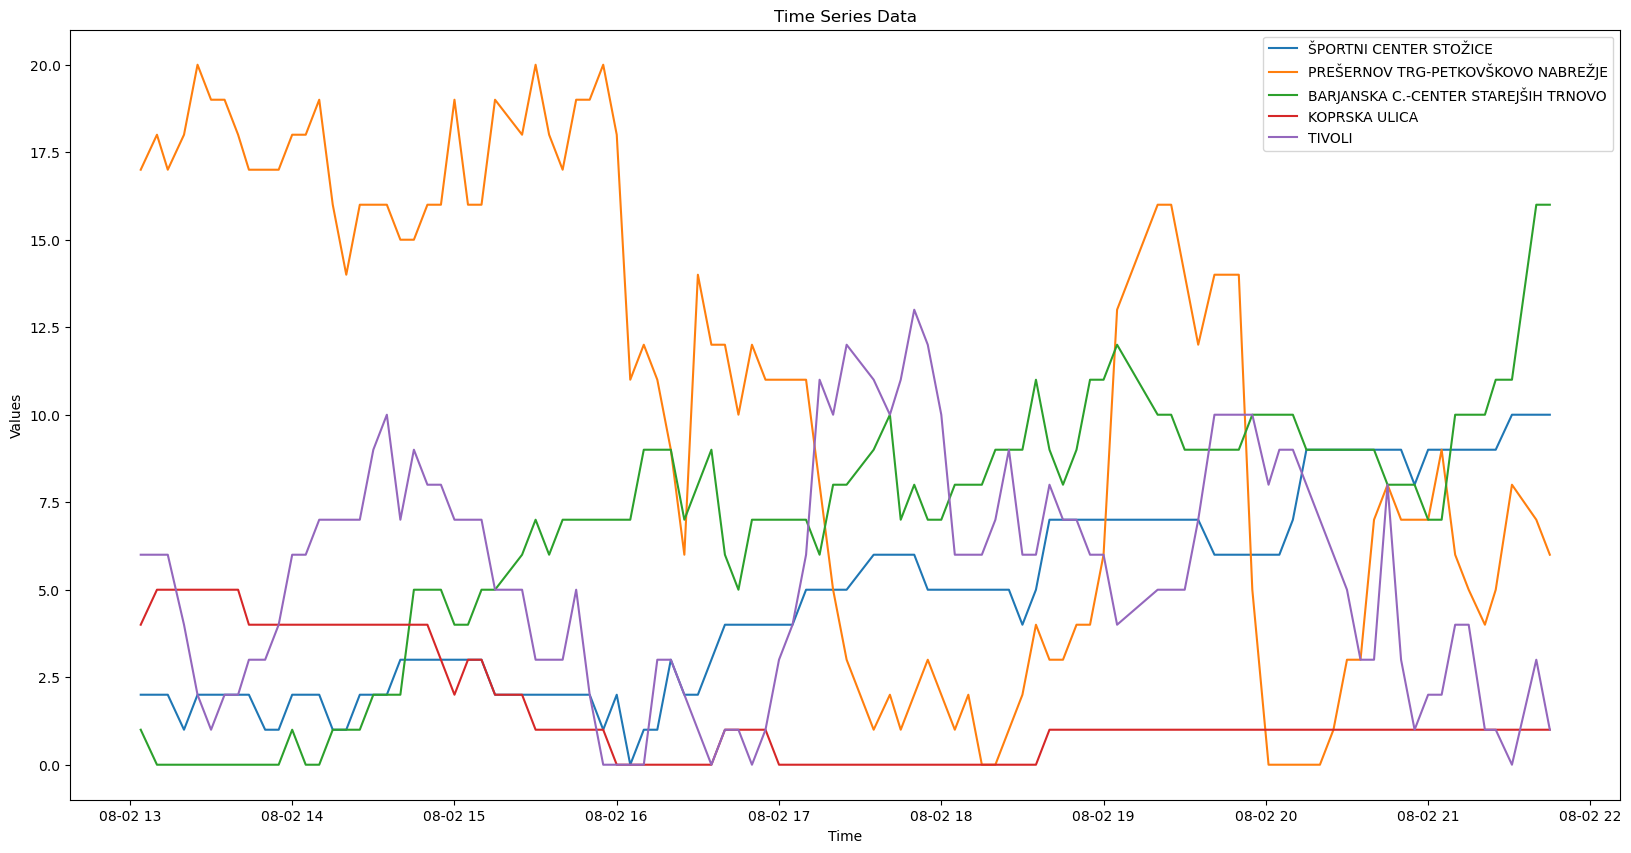

In [149]:
plot_bikes(train, n_stations=5)

In [202]:
# Train model for a single station
single_station_model = LinearRegression(1, 1)

lr = 0.01
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(single_station_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.7)


In [203]:
train_losses, test_losses, epochs = [], [], []

n_epochs = 10000

X_train = datetime64_to_unix(train["timestamp"].values)
X_test = datetime64_to_unix(test["timestamp"].values)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(train.iloc[:, 1].values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(test.iloc[:, 1].values, dtype=torch.float32).unsqueeze(1)



In [204]:
train_losses, test_losses, epochs = [], [], []

epochs, train_losses, test_losses = model_train(X_train, X_test, y_train, y_test, single_station_model, loss_fn, optimizer, n_epochs, epochs, train_losses, test_losses, scheduler)


Test loss: nan
Epoch: 0, Train loss: 8.044639531145626e+16
Test loss: nan
Epoch: 100, Train loss: 969728196608.0
Test loss: nan
Epoch: 200, Train loss: 69830840.0
Test loss: nan
Epoch: 300, Train loss: 1679.760498046875
Test loss: nan
Epoch: 400, Train loss: 42.74026870727539
Test loss: nan
Epoch: 500, Train loss: 42.68118667602539
Test loss: nan
Epoch: 600, Train loss: 42.68118667602539
Test loss: nan
Epoch: 700, Train loss: 42.68118667602539
Test loss: nan
Epoch: 800, Train loss: 42.68118667602539
Test loss: nan
Epoch: 900, Train loss: 42.68118667602539
Test loss: nan
Epoch: 1000, Train loss: 42.68118667602539
Test loss: nan
Epoch: 1100, Train loss: 42.68118667602539
Test loss: nan
Epoch: 1200, Train loss: 42.68118667602539
Test loss: nan
Epoch: 1300, Train loss: 42.68118667602539
Test loss: nan
Epoch: 1400, Train loss: 42.68118667602539
Test loss: nan
Epoch: 1500, Train loss: 42.68118667602539
Test loss: nan
Epoch: 1600, Train loss: 42.68118667602539
Test loss: nan
Epoch: 1700, Trai

In [195]:
len(epochs)

100

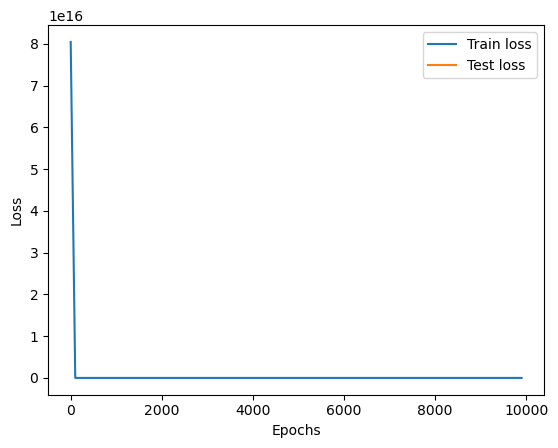

In [205]:
plot_loss(epochs, train_losses, test_losses)

In [207]:
with torch.inference_mode():
    y_pred = single_station_model(X_test.to(device))
    # print(y_pred.cpu())
    print(y_pred.cpu().detach().numpy().shape)

(40, 1)
